# PT Figure Notebook
## Sid Gurajala
## 05/01/2023

## Libraries 

In [1]:
set.seed(0)
library(Seurat)
library(dplyr) 
library(tidyr)
library(viridis)
library(stringr)
library(pheatmap)
library(presto)
library(pals)
library(harmony)
library(cowplot)
library(singlecellmethods)  
library(ggplot2)
library(lisi)
library(ggrastr, lib.loc = "/PHShome/ssg34/.conda/envs/plswork/lib/R/library")
#library(Cairo)
source("/data/srlab/anathan/scripts/scseq_utils.R")
library(parallel)
library('lme4', lib.loc = "/PHShome/ssg34/.conda/envs/jupy/lib/R/library")
library(glmmTMB, lib.loc ="/PHShome/ssg34/.conda/envs/jupy/lib/R/library")
.libPaths("/PHShome/ssg34/.conda/envs/plswork/lib/R/library")

plot_shuffled_features <- function(input_df, input_norm, feature, pct, pt_size) {
    
max.cutoff = quantile(input_norm[feature, input_df$cell], pct)
min.cutoff = quantile(input_norm[feature, input_df$cell], 1-pct)

plot_df <- input_df 
    
plot_df$norm_expression <- input_norm[feature, input_df$cell]
    
plot_df <- plot_df %>% 
                mutate(norm_expression = ifelse(norm_expression < min.cutoff, min.cutoff, norm_expression)) %>%
                mutate(norm_expression = ifelse(norm_expression > max.cutoff, max.cutoff, norm_expression)) 

p <- ggplot() +
        geom_point(
            data = plot_df[sample(nrow(plot_df)), ] %>% 
                      select(huwotUMAP1, huwotUMAP2, norm_expression), 
            aes(x = huwotUMAP1, y = huwotUMAP2, color = norm_expression),
            size = pt_size, stroke = 0.0001, shape = 20) +
      scale_color_viridis(name = "Expression") +
      labs(x="", y="", title = feature)+
      theme_classic(base_size = 20)+
      #facet_wrap(~dataset)+
      theme(
        legend.text = element_text(size = 10), 
        legend.title = element_text(size = 12),
        plot.title = element_text(color="black", size=25, face="bold.italic", hjust = 0.5),
        strip.text.x = element_text(size = 18),
          axis.text = element_blank(),
          axis.ticks = element_blank(),
          axis.line = element_blank()) 
return(p)
}

pivot_wilcox_expr <- function(wilcox_obj) {
    df <- wilcox_obj %>% select(group, feature, avgExpr) %>% 
                    pivot_wider(names_from = 'feature', values_from = 'avgExpr') %>% data.frame()
    rownames(df) <- df$group
    df <- df %>% select(-group) %>% as.matrix()
    return(df)
}

pivot_wilcox_logFC <- function(wilcox_obj) {
    df <- wilcox_obj %>% select(group, feature, logFC) %>% 
                    pivot_wider(names_from = 'feature', values_from = 'logFC') %>% data.frame()
    rownames(df) <- df$group
    df <- df %>% select(-group) %>% as.matrix()
    return(df)
}

pseudobulk <- function(individual, meta, norm) {
    cells <- meta %>% filter(sample == individual) %>% pull(cell)
    if (length(cells) > 2) {
        pb <- rowMeans(norm[, cells])
        pb <- c(pb, individual)
        names(pb) <- c(rownames(norm), 'sample')
        return(pb)
    }
}



de <- function(feature, df) {
    model_df <- df %>% select(feature, sample, Type, avg_count, avg_mt) %>% rename(Exp = feature)
    if (sum(model_df$Exp > 0) > 0.10 * nrow(model_df)) { 
        m_0 <- lm(Exp ~ log(avg_count) + avg_mt, data = model_df)
        m_1 <- lm(Exp ~ log(avg_count) + avg_mt + Type, data = model_df)
        ANNO <- anova(m_0, m_1)
        LRP <- ANNO[2,6]
        F <- ANNO[2,5]
        Beta <- summary(m_1)$coefficients['TypeLN', 'Estimate']
        SE <- summary(m_1)$coefficients['TypeLN', 'Std. Error']
        res <- c(gene = feature, LRP = LRP, F = F, Beta = Beta, SE = SE)
    }
    else {
        res <- c(gene = feature, LRP = NA, F = NA, Beta = NA, SE = NA)
    }
    return(res)
}

cna_cor <- function(gene, meta, norm) {
    if (sum(norm[gene, meta$cell]) > 0.1 * nrow(meta)) {
        cor_test <- cor.test(meta$ncorr, norm[gene, meta$cell])
        res <- c(gene, cor_test$estimate, cor_test$p.value)
    }
    else {
        res <- c(gene, NA, NA)
    }
    return(res)
}

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: viridisLite

Loading required package: Rcpp

Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘pals’


The following objects are masked from ‘package:viridis’:

    cividis, inferno, magma, plasma, turbo, viridis


The following objects are masked from ‘package:viridisLite’:

    cividis, inferno, magma, plasma, turbo, viridis



Attaching package: ‘singlecellmethods’


The following object is masked from ‘package:SeuratObject’:

    rowMeans


The following object is masked from ‘package:base’:

    rowMeans


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘p

In [ ]:
ind_meta <- all_meta %>% 
                    select(sample, broad.group) %>% 
                    table() %>% data.frame() %>% filter(broad.group != "UND")

In [ ]:
ind_keep <- vector() 

for (i in unique(ind_meta$sample)) {
    ind_subset <- ind_meta %>% filter(sample == i)
        if (all(ind_subset$Freq > 100)) {
            ind_keep <- c(ind_keep, i)
        }
}

In [ ]:
norm <- norm[, all_meta$cell]

In [ ]:
qq_pb_sc <- data.frame(nrow = nrow(norm))
individuals_sc <- vector()
cell_types_sc <- vector() 

for (i in ind_keep) {
    for (j in unique(ind_meta$broad.group)) {
            subset <- all_meta %>% filter(sample == i, 
                                                 broad.group == j,
                                                 dataset == "scRNAseq") %>% 
                        pull(cell)
            pb_vec <- rowMeans(norm[, subset])
            qq_pb_sc <- cbind(qq_pb_sc, pb_vec)
            individuals_sc <- c(individuals_sc, i)
            cell_types_sc <- c(cell_types_sc, j)
    }
}

qq_pb_sn <- data.frame(nrow = nrow(norm))
individuals_sn <- vector()
cell_types_sn <- vector() 

for (i in ind_keep) {
    for (j in unique(ind_meta$broad.group)) {
            subset <- all_meta %>% filter(sample == i, 
                                                 broad.group == j,
                                                 dataset == "snRNAseq") %>% 
                        pull(cell)
            pb_vec <- rowMeans(norm[, subset])
            qq_pb_sn <- cbind(qq_pb_sn, pb_vec)
            individuals_sn <- c(individuals_sn, i)
            cell_types_sn <- c(cell_types_sn, j)
    }
}

# PT

In [ ]:
pt_harmony <- readRDS('/data/srlab2/qxiao/AMP-SLE/sc_nuc_data/20230215_Tissue/PT/2023-04-06_harmony_500nGene_1000nUMI_3.rds')
pt_meta <- readRDS('/data/srlab2/qxiao/AMP-SLE/sc_nuc_data/20230215_Tissue/PT/2023-06-30_meta_500nGene_1000nUMI_3.rds')
pt_umap <- readRDS('/data/srlab2/qxiao/AMP-SLE/sc_nuc_data/20230215_Tissue/PT/2023-04-06_UMAPobject_500nGene_1000nUMI_3.rds')

In [13]:
qcd_meta <- readRDS('/data/srlab2/qxiao/AMP-SLE/sc_nuc_data/20230215_Tissue/PT/2023-06-30_meta_500nGene_1000nUMI_3.rds')

In [15]:
qcd_meta <- qcd_meta %>% rename(new_cluster_number = hres.0.4)

In [16]:
sn_control <- qcd_meta %>% filter(dataset == "snRNAseq", Type == "Control") %>% 
                group_by(new_cluster_number) %>% 
                summarize(samples = length(unique(sample)),
                          ncells = length(unique(cell))) %>% 
                mutate(sn_control = paste0(samples, " (", ncells, ")")) %>% select(new_cluster_number, sn_control)
sn_LN <- qcd_meta %>% filter(dataset == "snRNAseq", Type == "LN") %>% 
                group_by(new_cluster_number) %>% 
                summarize(samples = length(unique(sample)),
                          ncells = length(unique(cell))) %>% 
                mutate(sn_LN = paste0(samples, " (", ncells, ")")) %>% select(new_cluster_number, sn_LN)
sc_control <- qcd_meta %>% filter(dataset == "scRNAseq", Type == "Control") %>% 
                group_by(new_cluster_number) %>% 
                summarize(samples = length(unique(sample)),
                          ncells = length(unique(cell))) %>% 
                mutate(sc_control = paste0(samples, " (", ncells, ")")) %>% select(new_cluster_number, sc_control)
sc_LN <- qcd_meta %>% filter(dataset == "scRNAseq", Type == "LN") %>% 
                group_by(new_cluster_number) %>% 
                summarize(samples = length(unique(sample)),
                          ncells = length(unique(cell))) %>% 
                mutate(sc_LN = paste0(samples, " (", ncells, ")")) %>% select(new_cluster_number, sc_LN)
merged <- sc_LN %>% left_join(sc_control) %>% left_join(sn_LN) %>% left_join(sn_control)
merged[is.na(merged)] <- "0 (0)"
write.csv(merged, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/PT_summary_04152024.csv', quote = FALSE, row.names = FALSE)

Joining, by = "new_cluster_number"
Joining, by = "new_cluster_number"
Joining, by = "new_cluster_number"


In [18]:
write.csv(merged, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/PT_summary_04152024.csv', quote = FALSE, row.names = FALSE)

## PT SUBTYPES

In [2]:
pt_meta <- readRDS('/data/srlab2/qxiao/AMP-SLE/sc_nuc_data/20230215_Tissue/PT/2023-06-30_meta_500nGene_1000nUMI_3.rds')

In [5]:
final_annotation <- data.frame(hres.0.4 = as.factor(seq(0, 7)),
                               final_annotation = c("PT0. Late Injuryhigh",
                                                    "PT1. SLC7A7high ALBhigh S1/S2",
                                                    "PT2. Low Quality",
                                                    "PT3. PCK1high DXCRhigh S2/S3",
                                                    "PT4. ANPEPhigh APOMhigh S1/S2",
                                                    "PT5. Late Injurylow S1/S2",
                                                    "PT6. PKHD1high SLC3A1high S2/S3",
                                                    "PT7. DTL"))

In [ ]:
pt_meta <- pt_meta %>% left_join(percent_mito)
pt_meta <- pt_meta %>% left_join(final_annotation)

In [46]:
saveRDS(pt_meta %>% select(-c(Annot.separate, predicted_broad, predicted_fine)),
        '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/pt_meta_qcd_harmony_umap_clusternames_11302023.rds')

In [ ]:
pt_norm <- norm[, pt_meta$cell]
saveRDS(pt_norm, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/PT_qcd_norm_12072023.rds')

### CLUSTERING/CELL STATE ASSIGNMENTS

In [4]:
pt_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/pt_meta_qcd_harmony_umap_clusternames_11302023.rds')

In [6]:
pt_meta <- pt_meta %>% left_join(final_annotation)
cluster_center <- pt_meta %>%
                  group_by(hres.0.4, final_annotation) %>%
                  summarise_at(vars(huwotUMAP1, huwotUMAP2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)

Joining, by = "hres.0.4"
Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”


In [9]:
pt_meta %>% colnames()

[1] "cell"             "sample"           "dataset"          "Site"            
 [5] "Type"             "processing.batch" "nCount_RNA"       "nFeature_RNA"    
 [9] "broad.type"       "doublet_score"    "uwotUMAP1"        "uwotUMAP2"       
[13] "hPC-1"            "hPC-2"            "hPC-3"            "hPC-4"           
[17] "hPC-5"            "hPC-6"            "hPC-7"            "hPC-8"           
[21] "hPC-9"            "hPC-10"           "hPC-11"           "hPC-12"          
[25] "hPC-13"           "hPC-14"           "hPC-15"           "hPC-16"          
[29] "hPC-17"           "hPC-18"           "hPC-19"           "hPC-20"          
[33] "id"               "cc"               "huwotUMAP1"       "huwotUMAP2"      
[37] "hres.0.1"         "hres.0.2"         "hres.0.3"         "hres.0.4"        
[41] "hres.0.6"         "hres.0.8"         "hres.1.2"         "hres.1.6"        
[45] "hres.2.0"         "final_annotation"

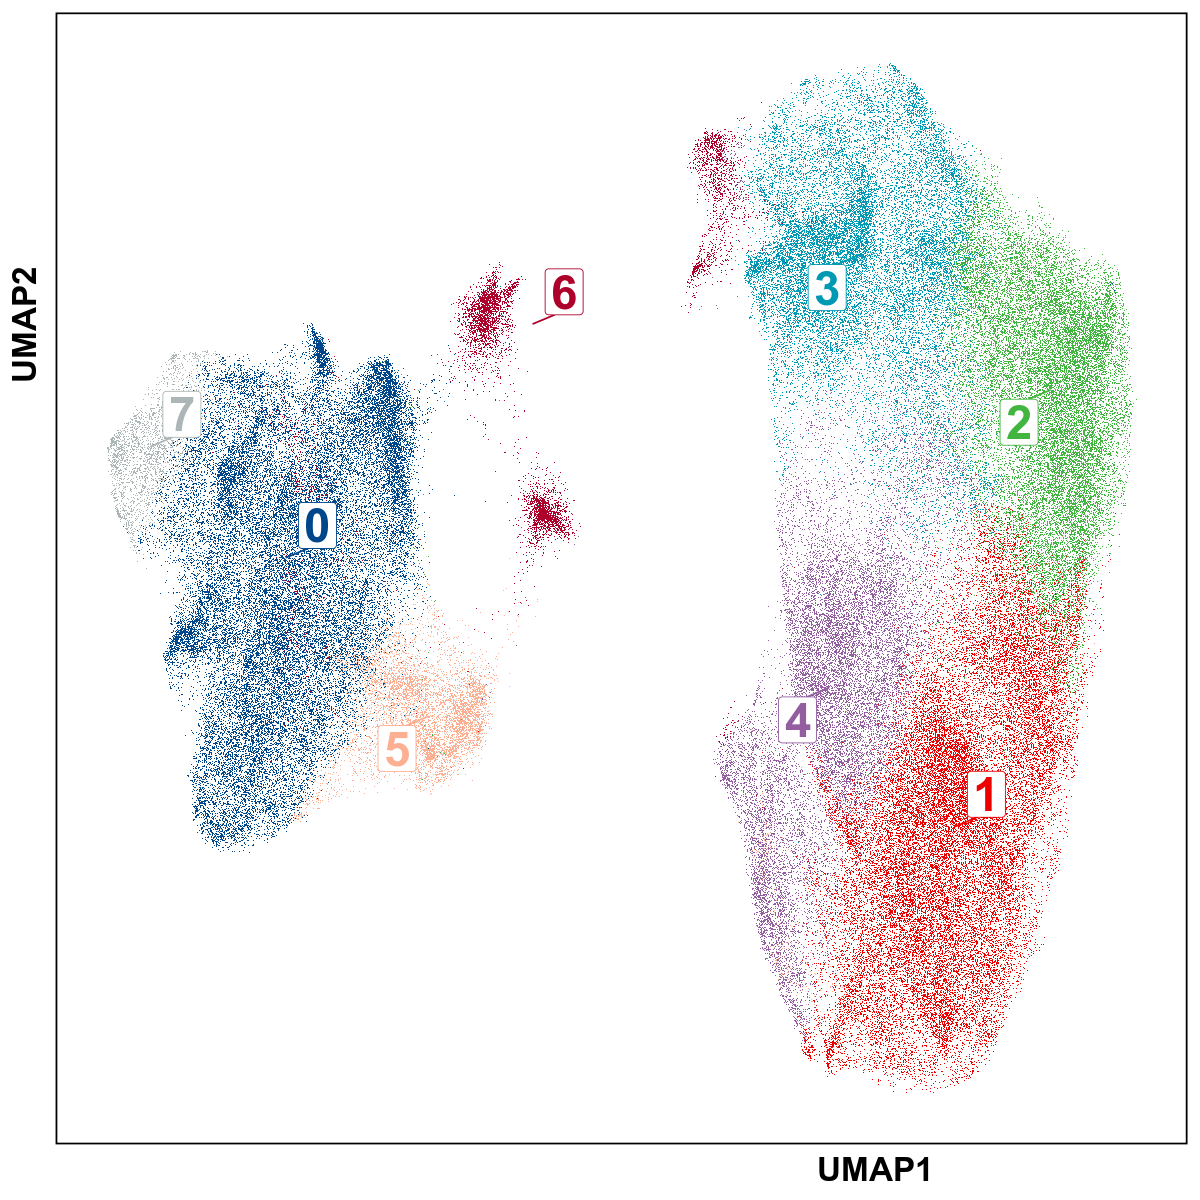

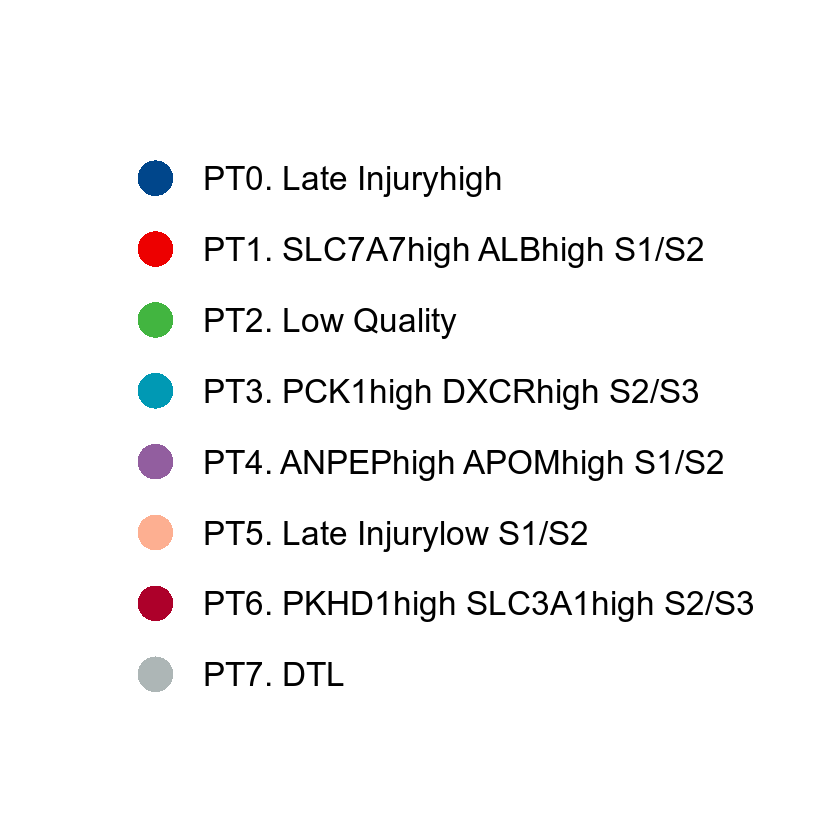

In [16]:
options(warn=-1)
cluster_center <- pt_meta %>%
                  group_by(hres.0.4, final_annotation) %>%
                  summarise_at(vars(huwotUMAP1, huwotUMAP2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)

options(repr.plot.height = 9, repr.plot.width = 18)
p <- ggplot() +
      geom_point(
       data = pt_meta[sample(nrow(pt_meta)), ] %>% 
      select(huwotUMAP1, huwotUMAP2, final_annotation, hres.0.4) %>% 
              mutate(hres.0.4 = as.factor(hres.0.4)),
        aes(x = huwotUMAP1, y = huwotUMAP2, color = final_annotation),
          size = 0.25, shape = 20, stroke = 0.0001) +
      ggrepel::geom_label_repel(
        data = cluster_center,
        aes(x = huwotUMAP1, y = huwotUMAP2, 
            label = hres.0.4, color = as.factor(final_annotation)),
        size = 10,  fontface = "bold",
        box.padding = unit(0.5, "lines"),
        point.padding = unit(0.01, "lines"),
        show.legend = FALSE
      ) +
    ggsci::scale_color_lancet()   +
    theme_classic(base_size = 15) +
      theme(
        legend.position = "right",
            #  plot.title = element_text(hjust = 0.5, 
            #                            size = 18, 
            #                            face = "bold"),
              axis.title = element_text(hjust = 0.75, 
                                        size = 20, 
                                        face = "bold"), 
              axis.text = element_blank(),
              axis.line = element_blank(),
              axis.ticks = element_blank(),
              panel.border = element_rect(colour = "black", fill=NA, size=1),
              legend.text = element_text(size = 20),
              legend.title = element_blank()
          
    ) +
    theme(text=element_text(family="Arial")) + 
        labs(x = "UMAP1", y = "UMAP2") +
        guides(color = guide_legend(ncol = 1, override.aes = list(size = 15)))
legend <- cowplot::get_legend(p)
p <- p + theme(legend.position = "none")
legend <- cowplot::plot_grid(legend)
cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/figure2/figure2d.png",
       p,
       base_height = 10,
       base_width = 10)
cowplot::save_plot("/data/srlab/ssg34/SLE_kidney_v2/figures/figure2/figure2d-legend.png",
       legend,
       base_height = 7,
       base_width = 7)
fig.size(10, 10)
p
fig.size(7, 7)
legend
options(warn=0)

In [ ]:
fig.size(10, 12)
plot_shuffled_features(pt_meta, 
                       norm, "CUBN", pct = 0.95, pt_size = 0.1)

In [ ]:
fig.size(8, 8)

plot_dist <- function(input_df, norm, feature)  {
    plot_df <- input_df %>% mutate(Exp = norm[feature, input_df$cell])
    p <- ggplot(plot_df, aes(x = hres.0.4, y = Exp, fill = dataset)) + 
            geom_violin(scale = "width") + 
            theme_classic(base_size = 20) + 
            labs(x = "Cluster", y = "Normalized Expression", title = feature) +
            theme(plot.title = element_text(size = 25, face = "bold.italic", hjust = 0.5))
    return(p)
}

In [ ]:
plot_dist(pt_meta, norm, "MOGAT1")
plot_dist(pt_meta, norm, "ABCC3")
plot_dist(pt_meta, norm, "SATB2")

In [ ]:
plot_dist(pt_meta, norm, "VCAM1")
plot_dist(pt_meta, norm, "TPM1")
plot_dist(pt_meta, norm, "DCDC2")

In [ ]:
plot_dist(pt_meta, norm, "ALDOB")
plot_dist(pt_meta, norm, "GATM")
plot_dist(pt_meta, norm, "APOE")

In [ ]:
#Pan DTL Markers 
#SATB2, JAG1, ADGRL3, ID1
plot_dist(pt_meta, norm, "JAG1")
plot_dist(pt_meta, norm, "TACSTD2")
plot_dist(pt_meta, norm, "ADGRL3")

In [ ]:
ggplot(pt_meta, 
       aes(x = as.factor(hres.0.4), y = as.numeric(doublet_score), fill = dataset)) + 
    geom_boxplot() + theme_classic(base_size = 20) + 
    labs(x = "cluster", y = "scrublet_score")




ggplot(pt_meta, 
       aes(x = as.factor(hres.0.4), y = log(as.numeric(nCount_RNA)), fill = dataset)) + 
    geom_boxplot() + theme_classic(base_size = 20) +
    labs(x = "cluster", y = "log(Counts Per Cell)")






ggplot(pt_meta,
       aes(x = as.factor(hres.0.4), y = log(as.numeric(nFeature_RNA)), fill = dataset)) + 
    geom_boxplot() + theme_classic(base_size = 20) + 
    labs(x = "cluster", y = "log(Genes Per Cell)")



In [ ]:
sc_meta <- pt_meta %>% filter(dataset == "scRNAseq")
sc_de <- wilcoxauc(norm[, sc_meta$cell], sc_meta$hres.0.4)
sn_meta <- pt_meta %>% filter(dataset == "snRNAseq")
sn_de <- wilcoxauc(norm[, sn_meta$cell], sn_meta$hres.0.4)

In [ ]:
#CRYAB, TACSTD2, SLC44A5, KLRG2, COL26A1, BOC
fig.size(10, 12)
plot_shuffled_features(pt_meta, 
                       norm, 
                       "MOGAT1", pct = 0.95) 

### SC vs SN Heatmap

In [ ]:
pt_norm <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/PT_qcd_norm_12072023.rds')
pt_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/pt_meta_qcd_harmony_umap_clusternames_11302023.rds')

In [ ]:
sc_meta <- pt_meta %>% filter(dataset == "scRNAseq")
sc_de <- wilcoxauc(pt_norm[, sc_meta$cell], sc_meta$final_annotation)

In [ ]:
sn_meta <- pt_meta %>% filter(dataset == "snRNAseq")
sn_de <- wilcoxauc(norm[, sn_meta$cell], sn_meta$final_annotation)

In [ ]:
genes <-  c("VCAM1", "TPM1", "DCDC2",
            "PRODH2", "SLC5A2", "PCK1", "DCXR",
            "SLC22A8", "SLC7A7",  "ALB",
            "ANPEP", "APOM", "SLC34A1", "SLC22A7",
             "MOGAT1", "ABCC3", "SATB2",  
             "PKHD1", "SLC3A1",   
             "JAG1", "TACSTD2")

In [ ]:
sc_plot_df <- sc_de %>%  filter(feature %in% genes) %>% 
                    select(group, feature, 
                           logFC, avgExpr, pct_in) %>% ungroup() %>% group_by(feature) %>% 
                    mutate(avgExpr_scaled = scale(avgExpr)) 
sn_plot_df <- sn_de %>%  filter(feature %in% genes) %>% 
                    select(group, feature, 
                           logFC, avgExpr, pct_in) %>% ungroup() %>% group_by(feature) %>% 
                    mutate(avgExpr_scaled = scale(avgExpr)) 

In [ ]:
fig.size(10, 15)
ggplot(sc_plot_df %>% rename(percent = pct_in,
                             zscore = avgExpr_scaled), 
               aes(x = feature, y = group, 
                   fill = zscore)) + 
    geom_tile() + 
    theme_classic(base_size = 12) + 
    scale_fill_gradient2(low = "blue",
                         mid = "white",
                         high= "red", 
                         limits=c(-2, 2), 
                         oob = scales::squish) + 
    scale_x_discrete(limits = genes) + 
    scale_y_discrete(limits = final_annotation$final_annotation) + 
    theme(axis.text.x = element_text(angle = 90),
          axis.text = element_text(face = "bold", size = 15),
          axis.title = element_text(size = 15)) + 
    labs(x = "", y = "")
fig.size(10, 15)
ggplot(sn_plot_df %>% rename(percent = pct_in,
                             zscore = avgExpr_scaled), 
               aes(x = feature, y = group, 
                   fill = zscore)) + 
    geom_tile() + 
    theme_classic(base_size = 12) + 
    scale_fill_gradient2(low = "blue",
                         mid = "white",
                         high= "red", 
                         limits=c(-2, 2), 
                         oob = scales::squish) + 
    scale_x_discrete(limits = genes) + 
    scale_y_discrete(limits = final_annotation$final_annotation) + 
    theme(axis.text.x = element_text(angle = 90),
          axis.text = element_text(face = "bold", size = 15),
          axis.title = element_text(size = 15)) + 
    labs(x = "", y = "")

### SC vs SN Cluster Freq

In [108]:
pt_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/pt_meta_qcd_harmony_umap_clusternames_11302023.rds')

In [4]:
pt_meta <- pt_meta  %>% 
                mutate(individual = str_split(sample, '_')) %>% 
                rowwise() %>% 
                mutate(individual = unlist(individual)[3]) 

In [ ]:
sample_freq <- pt_meta %>% select(dataset, individual, hres.0.4) %>% 
                    table() %>% data.frame() %>% 
                    pivot_wider(names_from = "hres.0.4", values_from = Freq) 

In [ ]:
ind_list <- pt_meta %>% select(dataset, individual) %>% 
                table() %>% data.frame() %>% 
                pivot_wider(names_from = 'dataset', values_from = "Freq") %>% filter(scRNAseq > 200 & snRNAseq > 200) %>% 
                pull(individual)

In [ ]:
sample_freq_sc <- sample_freq %>% 
                    filter(individual %in% ind_list) %>% 
                    select(- individual) %>% 
                    filter(dataset == "scRNAseq") %>% 
                    select(-dataset) %>% colSums()

sample_freq_sn <- sample_freq %>% 
                    filter(individual %in% ind_list) %>% 
                    select(- individual) %>% 
                    filter(dataset == "snRNAseq") %>% 
                    select(-dataset) %>% colSums()

In [ ]:
sample_freq <- data.frame(rep("a", 8))
sample_freq$sc_freq <- sample_freq_sc / sum(sample_freq_sc)
sample_freq$sc_se <- sqrt((sample_freq$sc_freq * (1 - sample_freq$sc_freq)) / sample_freq_sc)
sample_freq$sn_freq <- sample_freq_sn / sum(sample_freq_sn)
sample_freq$sn_se <- sqrt((sample_freq$sn_freq * (1 - sample_freq$sn_freq)) / sample_freq_sn)
sample_freq$hres.0.4 <- as.character(seq(0, 7))
sample_freq <- sample_freq[,- 1]

In [ ]:
fig.size(8, 8)

max_val <- max(sample_freq[, c("sc_freq", "sn_freq")])

ggplot(sample_freq, aes(x = sc_freq, y = sn_freq, color = hres.0.4)) + 
    geom_abline(linetype = "dashed") +
    ggsci::scale_color_lancet()   +
    theme_classic() + 
    geom_point(size = 4) + 
    geom_linerange(aes(ymax = sn_freq+1.96*sn_se, 
                        ymin = sn_freq-1.96*sn_se), alpha = 0.5) +
    geom_linerange(aes(xmax = sc_freq+1.96*sc_se, 
                        xmin = sc_freq-1.96*sc_se), alpha = 0.5) +
    theme(legend.position = "none",
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 18)) +
    coord_cartesian(xlim = c(0, 0.25), ylim = c(0, 0.25)) + 
    labs(x = "scRNAseq",
         y = "snRNAseq")

In [ ]:
cor.test(sample_freq$sc_freq, sample_freq$sn_freq)

In [67]:
lateinjury_high_prop <- pt_meta %>% 
                filter(dataset == 'scRNAseq') %>% 
                select(sample, final_annotation) %>% 
                table() %>% data.frame() %>% 
                group_by(sample) %>% mutate(Prop = Freq / sum(Freq)) %>% 
                filter(final_annotation == "PT0. Late Injuryhigh")
saveRDS(lateinjury_high_prop, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/injured_pt_highprop_singlecell_05102024.rds')
lateinjury_low_prop <- pt_meta %>% 
                filter(dataset == 'scRNAseq') %>% 
                select(sample, final_annotation) %>% 
                table() %>% data.frame() %>% 
                group_by(sample) %>% mutate(Prop = Freq / sum(Freq)) %>% 
                filter(final_annotation == "PT5. Late Injurylow S1/S2")
saveRDS(lateinjury_low_prop, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/injured_pt_lowprop_singlecell_05102024.rds')

In [333]:
lateinjury_high_prop <- pt_meta %>% 
                filter(dataset == 'snRNAseq') %>% 
                select(sample, final_annotation) %>% 
                table() %>% data.frame() %>% 
                group_by(sample) %>% mutate(Prop = Freq / sum(Freq)) %>% 
                filter(final_annotation == "PT0. Late Injuryhigh")
saveRDS(lateinjury_high_prop, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/injured_pt_highprop_singlenuc_05102024.rds')
lateinjury_low_prop <- pt_meta %>% 
                filter(dataset == 'snRNAseq') %>% 
                select(sample, final_annotation) %>% 
                table() %>% data.frame() %>% 
                group_by(sample) %>% mutate(Prop = Freq / sum(Freq)) %>% 
                filter(final_annotation == "PT5. Late Injurylow S1/S2")
saveRDS(lateinjury_low_prop, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/injured_pt_lowprop_singlenuc_05102024.rds')


	Pearson's product-moment correlation

data:  plot_df$scRNAseq and plot_df$snRNAseq
t = 6.1665, df = 48, p-value = 1.395e-07
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4742731 0.7959087
sample estimates:
      cor 
0.6648519 



	Pearson's product-moment correlation

data:  plot_df$scRNAseq and plot_df$snRNAseq
t = 3.3023, df = 48, p-value = 0.001816
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1725879 0.6328243
sample estimates:
      cor 
0.4302659 



	Pearson's product-moment correlation

data:  plot_df$scRNAseq and plot_df$snRNAseq
t = 3.3023, df = 48, p-value = 0.001816
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1725879 0.6328243
sample estimates:
      cor 
0.4302659 


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


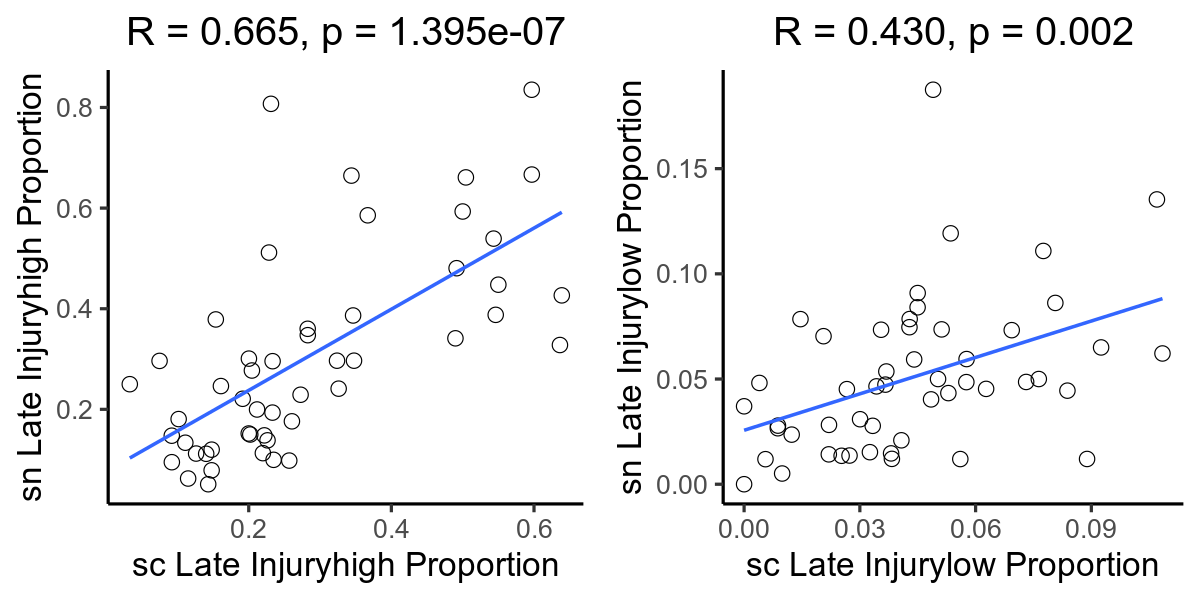

In [136]:
sn_list <- pt_meta %>% 
                filter(dataset == 'snRNAseq') %>% 
                pull(individual) %>% unique()
plot_df <- pt_meta %>% 
                select(individual, dataset, final_annotation) %>% 
                table() %>% data.frame() %>% 
                group_by(individual, dataset) %>% 
                mutate(Prop = Freq / sum(Freq)) %>% 
                filter(final_annotation == 'PT0. Late Injuryhigh') %>% 
                mutate(Prop = ifelse(is.na(Prop), 0, Prop)) %>% 
                select(individual, dataset, Prop) %>% 
                pivot_wider(names_from = 'dataset',
                            values_from = 'Prop')  %>% 
                filter(individual %in% sn_list)

cor.test(plot_df$scRNAseq, plot_df$snRNAseq)

p1 <- ggplot(plot_df, 
           aes(x = scRNAseq, y = snRNAseq)) +
    geom_point(shape = 21, size = 4) + 
    theme_classic(base_size = 20) + 
    geom_smooth(method = 'lm', se = FALSE) + 
    labs(x = 'sc Late Injuryhigh Proportion', 
         y = 'sn Late Injuryhigh Proportion',
         title = 'R = 0.665, p = 1.395e-07') + 
    theme(plot.title = element_text(hjust = 0.5))


plot_df <- pt_meta %>% 
                select(individual, dataset, final_annotation) %>% 
                table() %>% data.frame() %>% 
                group_by(individual, dataset) %>% 
                mutate(Prop = Freq / sum(Freq)) %>% 
                filter(final_annotation == "PT5. Late Injurylow S1/S2") %>% 
                mutate(Prop = ifelse(is.na(Prop), 0, Prop)) %>% 
                select(individual, dataset, Prop) %>% 
                pivot_wider(names_from = 'dataset',
                            values_from = 'Prop')  %>% 
                filter(individual %in% sn_list)

cor.test(plot_df$scRNAseq, plot_df$snRNAseq)

cor.test(plot_df$scRNAseq, plot_df$snRNAseq)

p2 <- ggplot(plot_df, 
           aes(x = scRNAseq, y = snRNAseq)) +
    geom_point(shape = 21, size = 4) + 
    theme_classic(base_size = 20) + 
    geom_smooth(method = 'lm', se = FALSE) + 
    labs(x = 'sc Late Injurylow Proportion', 
         y = 'sn Late Injurylow Proportion',
         title = 'R = 0.430, p = 0.002') + 
    theme(plot.title = element_text(hjust = 0.5))
cowplot::plot_grid(p1, p2)


	Pearson's product-moment correlation

data:  plot_df$LateInjuryHigh and plot_df$LateInjuryLow
t = 5.2198, df = 183, p-value = 4.83e-07
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2275377 0.4793620
sample estimates:
      cor 
0.3599891 


`geom_smooth()` using formula = 'y ~ x'


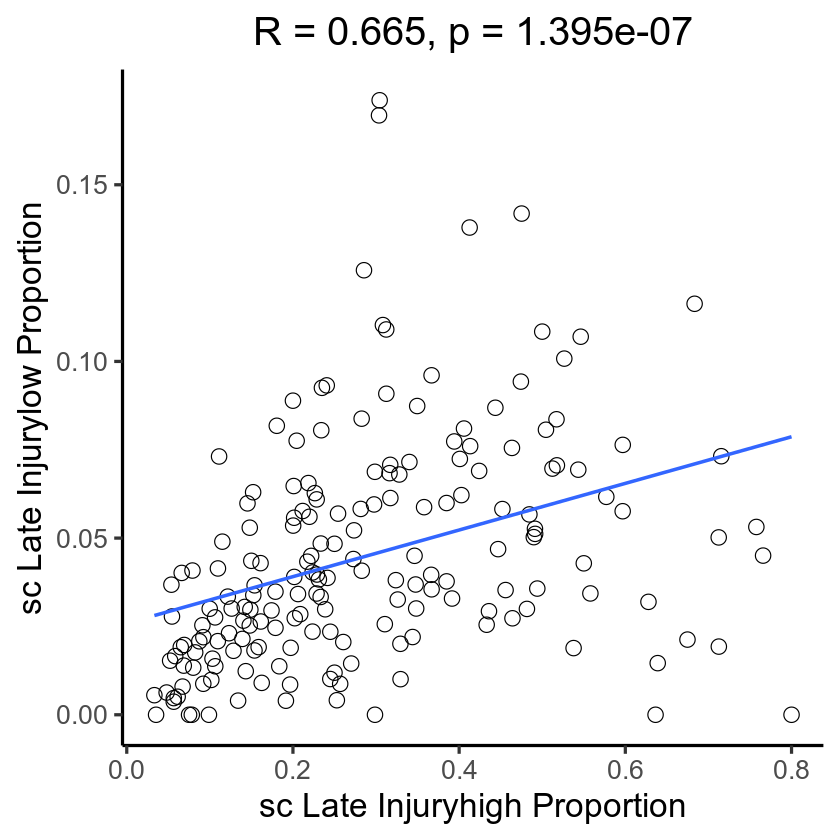

In [44]:
plot_df <- pt_meta %>% filter(dataset == 'scRNAseq') %>% 
                select(individual, final_annotation) %>% 
                table() %>% data.frame() %>% 
                group_by(individual) %>% 
                mutate(Prop = Freq / sum(Freq)) %>% 
                filter(final_annotation %in% c('PT0. Late Injuryhigh',
                                               "PT5. Late Injurylow S1/S2")) %>% 
                mutate(Prop = ifelse(is.na(Prop), 0, Prop)) %>% 
                select(individual, final_annotation, Prop) %>% 
                pivot_wider(names_from = 'final_annotation',
                            values_from = 'Prop')
colnames(plot_df) <- c("individual", "LateInjuryHigh", "LateInjuryLow")

cor.test(plot_df$LateInjuryHigh, plot_df$LateInjuryLow)

ggplot(plot_df, 
           aes(x = LateInjuryHigh, y = LateInjuryLow)) +
    geom_point(shape = 21, size = 4) + 
    theme_classic(base_size = 20) + 
    geom_smooth(method = 'lm', se = FALSE) + 
    labs(x = 'sc Late Injuryhigh Proportion', 
         y = 'sc Late Injurylow Proportion',
         title = 'R = 0.360, p = 4.83e-07') + 
    theme(plot.title = element_text(hjust = 0.5))

## CASE/CONTROL

In [ ]:
first_biop_pred <- readRDS("/data/srlab2/qxiao/AMP-SLE/data/clinical/df_pred_biop.rds") %>% 
                        mutate(individual = str_split(Subject_ID, '-')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2])


sc_meta <- pt_meta[, !colnames(pt_meta) %in% colnames(clinical)] %>% 
                        mutate(kid_sample = pt_meta$sample) %>% 
                        filter(dataset == 'scRNAseq') %>% 
                        mutate(individual = str_split(kid_sample, '_')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[3]) %>% 
                        left_join(clinical) %>% 
                        left_join(first_biop_pred) %>% 
                        select(c(cell, paste0('hPC-', 1:20), Sex, huwotUMAP1, huwotUMAP2, sample, final_annotation,
                                 Responder.Status, Age, Race, Final_ISN, Final_Chronicity, Final_Activity, Type, Final_Site,
                                 First_biop, Pred_use)) 

sn_meta <- pt_meta[, !colnames(pt_meta) %in% colnames(clinical)] %>% 
                        mutate(kid_sample = pt_meta$sample) %>% 
                        filter(dataset == 'snRNAseq') %>% 
                        mutate(individual = str_split(kid_sample, '_')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[3]) %>% 
                        left_join(clinical) %>% 
                        left_join(first_biop_pred) %>% 
                        select(c(cell, paste0('hPC-', 1:20), Sex, huwotUMAP1, huwotUMAP2, sample, final_annotation,
                                 Responder.Status, Age, Race, Final_ISN, Final_Chronicity, Final_Activity, Type, Final_Site,
                                 First_biop, Pred_use)) 

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('UMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Type)]

meta <- meta[ind, ]
umap <- umap[ind, ]
harmony <- harmony[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Case.Control = c(0, 1),
                                      Type = c("Control", "LN")))

meta <- meta %>% left_join(data.frame(Responder_Status = c(0, 1, 2),
                                      Responder.Status = c("NR", "PR", "CR")))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/sn_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/sn_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/sn_umap.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Type)]

meta <- meta[ind, ]
umap <- umap[ind, ]
harmony <- harmony[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Case.Control = c(0, 1),
                                      Type = c("Control", "LN")))

meta <- meta %>% left_join(data.frame(Responder_Status = c(0, 1, 2),
                                      Responder.Status = c("NR", "PR", "CR")))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/sc_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/sc_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/sc_umap.csv', 
          row.names = FALSE, quote = FALSE)

### DE

In [ ]:
pt_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/pt_meta_qcd_harmony_umap_clusternames_11302023.rds')
pt_norm <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/PT_qcd_norm_12072023.rds')

In [ ]:
out <- mclapply(unique(pt_meta$sample), pseudobulk, pt_meta, pt_norm,
               mc.cores = 6)
pt_pb <- data.frame(do.call(rbind, out))

In [ ]:
sample_stats <- pt_meta %>% group_by(sample) %>% summarize(avg_count = mean(nCount_RNA), avg_mt = mean(percent.mt))
pt_pb <- pt_pb %>% left_join(sample_stats) %>% left_join(unique(pt_meta %>% select(sample, Type)))
pt_pb <- pt_pb[grep("cells", pt_pb$sample), ]
colnames(pt_pb)[1:36601] <- rownames(pt_norm)

In [ ]:
saveRDS(pt_pb, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/PT_norm_pseudobulk_12072023.rds')

In [ ]:
pt_pb <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/PT_norm_pseudobulk_12072023.rds')

In [ ]:
de_out <- mclapply(colnames(pt_pb)[1:36601], de, pt_pb, mc.cores = 20)

In [ ]:
de_df <- data.frame(do.call(rbind, de_out)) %>% mutate(LRP = as.numeric(LRP),
                                                       F = as.numeric(F),
                                                       Beta = as.numeric(Beta),
                                                       SE = as.numeric(SE))

In [ ]:
saveRDS(de_df, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/PT_case_control_differential_expression_120722023.rds')

In [ ]:
de_df <- de_df %>% na.omit()

In [ ]:
genes <- c('FKBP5', 'ZBTB16', 'PDK4', 'KLF6',
           'B2M', 'SPP1', 'NAT8', 'IFI27', 'IFI6')

In [ ]:
fig.size(6, 6)
ggplot(de_df,
                aes(x = Beta, y = -log10(LRP))) +
    geom_point(colour = 'lightgrey') + 
    geom_point(data = de_df %>% filter(LRP < 0.05/nrow(de_df) & abs(Beta) >= 0.3,
                                        ! gene %in% genes),
                   aes(x = Beta, y = -log10(LRP)),  color = "blue", size = 1) +
    geom_point(data = de_df %>% filter(gene %in% genes),
                   aes(x = Beta, y = -log10(LRP)),  color = "blue", size = 3)  + 
    geom_vline(xintercept = c(-0.3, 0.3), linetype = "dashed") + 
    geom_hline(yintercept = -log10(0.05/nrow(de_df)), linetype = "dashed") + 
    theme_classic() + 
    theme(legend.position = "none",
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 18),
          plot.title = element_text(size = 25, hjust = 0.5, face = "bold")) +
    ggrepel::geom_text_repel(data = de_df %>% 
                                     mutate(label = ifelse(LRP < 0.05/nrow(de_df) & abs(Beta) >= 0.3 | 
                                                           gene %in% genes, gene, NA),
                                            label_size = ifelse(gene %in% genes, 6 , 3)),
                                     aes(x = Beta, y = -log10(LRP), 
                                         size = label_size, label = label)
            , color = "black") +
    scale_size_identity() + 
    labs(x = "Case/Control Beta", y = "-log10(Pvalue)", title = "PT")

### RESULTS

In [ ]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/sc_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/sc_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/sc_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/sc_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr <- fdrs %>% filter(fdr < 0.05) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% mutate(ifelse(abs(meta$ncorr) > fdr, ncorr, NA))
tmp_meta <- cbind(tmp_meta, umap)

fig.size(8, 8)
ggplot() + 
      geom_point(data = pt_meta,
                aes(x = huwotUMAP1, y = huwotUMAP2), color = 'lightgrey', size = 0.75, stroke = 0.0001, shape = 20) + 
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = huwotUMAP1, y = huwotUMAP2, color = correlation), size = 0.75, stroke = 0.0001, shape = 20) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
     # labs(x="UMAP1", y="UMAP2", title = "Myeloid Chronicity: p = 2.00e-04") +
theme_classic(base_size = 15) +
  theme(
   # legend.position = "bottom",
   # legend.key.width = unit(1, 'cm'),
    legend.position  = "none",
          plot.title = element_text(hjust = 0.5, 
                                    size = 18, 
                                    face = "bold"),
          axis.title = element_text(hjust = 0.75, 
                                    size = 20, 
                                    face = "bold"), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          legend.title = element_text(face = "italic"),
          panel.border = element_rect(colour = "black", fill=NA, size=1)
) +
    labs(x="", y="", title = "", color = "r")


pos_fdr_thresh <- fdr
neg_fdr_thresh <- -1 * fdr


interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(6, 12)

cluster_order <- meta %>% 
                    select(ncorr, final_annotation) %>% 
                    group_by(final_annotation) %>% 
                    summarize(avg = mean(ncorr)) %>% 
                    arrange(desc(avg)) %>% pull(final_annotation)


ggplot(meta, aes(y = reorder(final_annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    scale_y_discrete(limits = cluster_order) +
    labs(x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

In [ ]:
subset <- c("PT3. PCK1high DXCRhigh S2/S3", "PT5. Late Injurylow S1/S2", "PT6. PKHD1high SLC3A1high S2/S3")

ggplot(meta, aes(y = reorder(final_annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    scale_y_discrete(limits = subset) +
    labs(x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 25, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

In [ ]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/sn_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/sn_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/sn_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/sn_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr <- fdrs %>% filter(fdr < 0.05) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% mutate(ifelse(abs(meta$ncorr) > fdr, ncorr, NA))
tmp_meta <- cbind(tmp_meta, umap)

fig.size(8, 8)
ggplot() + 
      geom_point(data = pt_meta,
                aes(x = huwotUMAP1, y = huwotUMAP2), color = 'lightgrey', size = 0.75, stroke = 0.0001, shape = 20) + 
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = huwotUMAP1, y = huwotUMAP2, color = correlation), size = 0.75, stroke = 0.0001, shape = 20) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
     # labs(x="UMAP1", y="UMAP2", title = "Myeloid Chronicity: p = 2.00e-04") +
theme_classic(base_size = 15) +
  theme(
    legend.position = "bottom",
    legend.key.width = unit(1, 'cm'),
  # legend.position = "none",
          plot.title = element_text(hjust = 0.5, 
                                    size = 18, 
                                    face = "bold"),
          axis.title = element_text(hjust = 0.75, 
                                    size = 20, 
                                    face = "bold"), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          legend.title = element_text(face = "italic"),
          panel.border = element_rect(colour = "black", fill=NA, size=1)
) +
    labs(x="", y="", title = "", color = "r")


pos_fdr_thresh <- fdr
neg_fdr_thresh <- -1 * fdr


interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(6, 12)


ggplot(meta, aes(y = reorder(final_annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    scale_y_discrete(limits = cluster_order) +
    labs( x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

In [ ]:
subset <- c("PT3. PCK1high DXCRhigh S2/S3", "PT5. Late Injurylow S1/S2", "PT6. PKHD1high SLC3A1high S2/S3")

ggplot(meta, aes(y = reorder(final_annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    scale_y_discrete(limits = subset) +
    labs(x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 25, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

In [45]:
sc_meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/sc_meta.csv')
sc_ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/sc_ncorr.csv", header = FALSE)
sc_meta$ncorr <- sc_ncorr$V1
sn_meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/sn_meta.csv')
sn_ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/sn_ncorr.csv", header = FALSE)
sn_meta$ncorr <- sn_ncorr$V1

final_annotation <- data.frame(hres.0.4 = as.factor(seq(0, 7)),
                               final_annotation = c("PT0. Late Injuryhigh",
                                                    "PT1. SLC7A7high ALBhigh S1/S2",
                                                    "PT2. Low Quality",
                                                    "PT3. PCK1high DXCRhigh S2/S3",
                                                    "PT4. ANPEPhigh APOMhigh S1/S2",
                                                    "PT5. Late Injurylow S1/S2",
                                                    "PT6. PKHD1high SLC3A1high S2/S3",
                                                    "PT7. DTL"))

sc_meta <- left_join(sc_meta, final_annotation) %>% mutate(new_cluster_number = hres.0.4)
sn_meta <- left_join(sn_meta, final_annotation) %>% mutate(new_cluster_number = hres.0.4)

sc_summary <- sc_meta %>% 
                select(new_cluster_number, cell, ncorr) %>% 
                group_by(new_cluster_number) %>% 
                summarize(sc.ncorr.ci = paste0("(", round(mean(ncorr) - 1.96 * sd(ncorr) / sqrt(length(cell)), 3),
                                      ", ", round(mean(ncorr) + 1.96 * sd(ncorr) / sqrt(length(cell)), 3), ")"))
sn_summary <-  sn_meta %>% 
                select(new_cluster_number, cell, ncorr) %>% 
                group_by(new_cluster_number) %>% 
                summarize(sn.ncorr.ci = paste0("(", round(mean(ncorr) - 1.96 * sd(ncorr) / sqrt(length(cell)), 3),
                                      ", ", round(mean(ncorr) + 1.96 * sd(ncorr) / sqrt(length(cell)), 3), ")"))
summary <- sc_summary %>% left_join(sn_summary)
write.table(summary, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/pt_casecontrol_corr_04152024.csv', 
              quote = FALSE, row.names = FALSE, sep = "\t")

Joining, by = "final_annotation"
Joining, by = "final_annotation"
Joining, by = "new_cluster_number"


### GEX corr with CNA

In [ ]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/sc_meta.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/sc_ncorr.csv", header = FALSE)
meta$ncorr <- ncorr$V1
norm <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/PT_qcd_norm_12072023.rds')

In [ ]:
start <- Sys.time()
out <- mclapply(rownames(norm)[1:1000], cna_cor, meta, norm, mc.cores = 24)
Sys.time() - start

### 4th Quantile Chronicity Versus Controls

In [ ]:
thresh <- quantile(na.omit(clinical$Final_Chronicity))[4]

meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('UMAP', colnames(sn_meta))]))) %>% 
                    filter(Final_Chronicity >= thresh | Type == "Control")
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Type)]

meta <- meta[ind, ]
umap <- umap[ind, ]
harmony <- harmony[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Case.Control = c(0, 1),
                                      Type = c("Control", "LN")))

meta <- meta %>% left_join(data.frame(Responder_Status = c(0, 1, 2),
                                      Responder.Status = c("NR", "PR", "CR")))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/high_chronicity_sn_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/high_chronicity_sn_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/high_chronicity_sn_umap.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
thresh <- quantile(na.omit(clinical$Final_Chronicity))[4]


meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))]))) %>% 
                    filter(Final_Chronicity >= thresh | Type == "Control")
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Type)]

meta <- meta[ind, ]
umap <- umap[ind, ]
harmony <- harmony[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Case.Control = c(0, 1),
                                      Type = c("Control", "LN")))

meta <- meta %>% left_join(data.frame(Responder_Status = c(0, 1, 2),
                                      Responder.Status = c("NR", "PR", "CR")))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/high_chronicity_sc_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/high_chronicity_sc_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/high_chronicity_sc_umap.csv', 
          row.names = FALSE, quote = FALSE)

#### CNA RESULTS

In [ ]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/high_chronicity_sc_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/high_chronicity_sc_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/high_chronicity_sc_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/high_chronicity_sc_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr <- fdrs %>% filter(fdr < 0.05) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% mutate(ifelse(abs(meta$ncorr) > fdr, ncorr, NA))
tmp_meta <- cbind(tmp_meta, umap)

fig.size(8, 8)
ggplot() + 
      geom_point(data = pt_meta,
                aes(x = huwotUMAP1, y = huwotUMAP2), color = 'lightgrey', size = 0.75, stroke = 0.0001, shape = 20) + 
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = huwotUMAP1, y = huwotUMAP2, color = correlation), size = 0.75, stroke = 0.0001, shape = 20) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
     # labs(x="UMAP1", y="UMAP2", title = "Myeloid Chronicity: p = 2.00e-04") +
theme_classic(base_size = 15) +
  theme(
   # legend.position = "bottom",
   # legend.key.width = unit(1, 'cm'),
    legend.position  = "none",
          plot.title = element_text(hjust = 0.5, 
                                    size = 18, 
                                    face = "bold"),
          axis.title = element_text(hjust = 0.75, 
                                    size = 20, 
                                    face = "bold"), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          legend.title = element_text(face = "italic"),
          panel.border = element_rect(colour = "black", fill=NA, size=1)
) +
    labs(x="", y="", title = "", color = "r")


pos_fdr_thresh <- fdr
neg_fdr_thresh <- -1 * fdr


interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(6, 12)

cluster_order <- meta %>% 
                    select(ncorr, final_annotation) %>% 
                    group_by(final_annotation) %>% 
                    summarize(avg = mean(ncorr)) %>% 
                    arrange(desc(avg)) %>% pull(final_annotation)


ggplot(meta, aes(y = reorder(final_annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    scale_y_discrete(limits = cluster_order) +
    labs(x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

In [ ]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/high_chronicity_sn_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/high_chronicity_sn_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/high_chronicity_sn_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/high_chronicity_sn_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr <- fdrs %>% filter(fdr < 0.05) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% mutate(ifelse(abs(meta$ncorr) > fdr, ncorr, NA))
tmp_meta <- cbind(tmp_meta, umap)

fig.size(8, 8)
ggplot() + 
      geom_point(data = pt_meta,
                aes(x = huwotUMAP1, y = huwotUMAP2), color = 'lightgrey', size = 0.75, stroke = 0.0001, shape = 20) + 
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = huwotUMAP1, y = huwotUMAP2, color = correlation), size = 0.75, stroke = 0.0001, shape = 20) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
     # labs(x="UMAP1", y="UMAP2", title = "Myeloid Chronicity: p = 2.00e-04") +
theme_classic(base_size = 15) +
  theme(
   # legend.position = "bottom",
   # legend.key.width = unit(1, 'cm'),
    legend.position  = "none",
          plot.title = element_text(hjust = 0.5, 
                                    size = 18, 
                                    face = "bold"),
          axis.title = element_text(hjust = 0.75, 
                                    size = 20, 
                                    face = "bold"), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          legend.title = element_text(face = "italic"),
          panel.border = element_rect(colour = "black", fill=NA, size=1)
) +
    labs(x="", y="", title = "", color = "r")


pos_fdr_thresh <- fdr
neg_fdr_thresh <- -1 * fdr


interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(6, 12)

cluster_order <- meta %>% 
                    select(ncorr, final_annotation) %>% 
                    group_by(final_annotation) %>% 
                    summarize(avg = mean(ncorr)) %>% 
                    arrange(desc(avg)) %>% pull(final_annotation)


ggplot(meta, aes(y = reorder(final_annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    scale_y_discrete(limits = cluster_order) +
    labs(x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

In [ ]:
meta %>% filter(final_annotation == "PT0. Late Injuryhigh")

### 4th Quantile Activity Versus Controls

In [ ]:
thresh <- quantile(na.omit(clinical$Final_Activity))[4]

meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('UMAP', colnames(sn_meta))]))) %>% 
                    filter(Final_Activity >= thresh | Type == "Control")
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Type)]

meta <- meta[ind, ]
umap <- umap[ind, ]
harmony <- harmony[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Case.Control = c(0, 1),
                                      Type = c("Control", "LN")))

meta <- meta %>% left_join(data.frame(Responder_Status = c(0, 1, 2),
                                      Responder.Status = c("NR", "PR", "CR")))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/high_activity_sn_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/high_activity_sn_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/high_activity_sn_umap.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
thresh <- quantile(na.omit(clinical$Final_Activity))[4]


meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))]))) %>% 
                    filter(Final_Activity >= thresh | Type == "Control")
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Type)]

meta <- meta[ind, ]
umap <- umap[ind, ]
harmony <- harmony[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Case.Control = c(0, 1),
                                      Type = c("Control", "LN")))

meta <- meta %>% left_join(data.frame(Responder_Status = c(0, 1, 2),
                                      Responder.Status = c("NR", "PR", "CR")))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/high_activity_sc_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/high_activity_sc_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/high_activity_sc_umap.csv', 
          row.names = FALSE, quote = FALSE)

### CLASS V Versus Controls

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('UMAP', colnames(sn_meta))]))) %>% 
                    filter(Final_ISN == "[V]" | Type == "Control")
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Type)]

meta <- meta[ind, ]
umap <- umap[ind, ]
harmony <- harmony[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Case.Control = c(0, 1),
                                      Type = c("Control", "LN")))

meta <- meta %>% left_join(data.frame(Responder_Status = c(0, 1, 2),
                                      Responder.Status = c("NR", "PR", "CR")))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/class_V_sn_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/class_V_sn_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/class_V_sn_umap.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('UMAP', colnames(sc_meta))]))) %>% 
                    filter(Final_ISN == "[V]" | Type == "Control")
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Type)]

meta <- meta[ind, ]
umap <- umap[ind, ]
harmony <- harmony[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Case.Control = c(0, 1),
                                      Type = c("Control", "LN")))

meta <- meta %>% left_join(data.frame(Responder_Status = c(0, 1, 2),
                                      Responder.Status = c("NR", "PR", "CR")))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/class_V_sc_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/class_V_sc_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/case_control/class_V_sc_umap.csv', 
          row.names = FALSE, quote = FALSE)

## WITHIN CASES

In [24]:
pt_meta <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/pt_meta_qcd_harmony_umap_clusternames_11302023.rds')

clinical <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/clinical_data_05042023.rds') %>% 
                        rename(Final_Site = Site) %>% select(-sample)

first_biop_pred <- readRDS("/data/srlab2/qxiao/AMP-SLE/data/clinical/df_pred_biop.rds") %>% 
                        mutate(individual = str_split(Subject_ID, '-')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[2])


sc_meta <- pt_meta %>% filter(dataset == 'scRNAseq', Type == "LN") %>% 
                        select(- colnames(pt_meta)[colnames(pt_meta) %in% colnames(clinical)]) %>% 
                        mutate(individual = str_split(sample, '_')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[3]) %>% 
                        left_join(clinical) %>% 
                        left_join(first_biop_pred) %>% 
                        select(c(cell, paste0('hPC-', 1:20), Sex, huwotUMAP1, huwotUMAP2, sample, final_annotation,
                                 Responder.Status, Age, Race, Final_ISN, Final_Chronicity, Final_Activity, Type, Final_Site,
                                 First_biop, Pred_use)) 

sn_meta <- pt_meta %>% filter(dataset == 'snRNAseq', Type == "LN") %>% 
                        select(- colnames(pt_meta)[colnames(pt_meta) %in% colnames(clinical)]) %>% 
                        mutate(individual = str_split(sample, '_')) %>% 
                        rowwise() %>% 
                        mutate(individual = unlist(individual)[3]) %>% 
                        left_join(clinical) %>% 
                        left_join(first_biop_pred) %>% 
                        select(c(cell, paste0('hPC-', 1:20), Sex, huwotUMAP1, huwotUMAP2, sample, final_annotation,
                                 Responder.Status, Age, Race, Final_ISN, Final_Chronicity, Final_Activity, Type, Final_Site,
                                 First_biop, Pred_use)) 

Joining, by = "individual"
Joining, by = "individual"
Joining, by = "individual"
Joining, by = "individual"


## AGE

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Age)]

meta <- meta[ind, ]
umap <- umap[ind, ]
harmony <- harmony[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sn_meta_age.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sn_harmony_age.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sn_umap_age.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Age)]

meta <- meta[ind, ]
umap <- umap[ind, ]
harmony <- harmony[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sc_meta_age.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sc_harmony_age.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sc_umap_age.csv', 
          row.names = FALSE, quote = FALSE)

## SEX

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[which(meta$Sex %in% c("Female", "Male"))]
meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sn_meta_sex.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sn_harmony_sex.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sn_umap_sex.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[which(meta$Sex %in% c("Female", "Male"))]
meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")
write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sc_meta_sex.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sc_harmony_sex.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sc_umap_sex.csv', 
          row.names = FALSE, quote = FALSE)

## RESPONSE

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[which(meta$Responder.Status %in% c("NR", "CR", "PR"))]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sn_meta_response.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sn_harmony_response.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sn_umap_response.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[which(meta$Responder.Status %in% c("NR", "CR", "PR"))]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")



write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sc_meta_response.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sc_harmony_response.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sc_umap_response.csv', 
          row.names = FALSE, quote = FALSE)

## RACE

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Race)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sn_meta_race.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sn_harmony_race.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sn_umap_race.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Race)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sc_meta_race.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sc_harmony_race.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sc_umap_race.csv', 
          row.names = FALSE, quote = FALSE)

### RESULTS

#### [W]

In [ ]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sc_meta_race.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sc_umap_race.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sc_race_[W]_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sc_race_[W]_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr_10 <- fdrs %>% filter(fdr < 0.1) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% 
                    mutate(ncorr = ifelse(abs(meta$ncorr) > fdr_10, ncorr, NA)) 
tmp_meta <- tmp_meta %>% cbind(umap)

fig.size(8, 8)
ggplot() + 
      geom_point(data = pt_meta,
                 aes(x = huwotUMAP1, y = huwotUMAP2), color = 'lightgrey', alpha = 0.1) +
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = huwotUMAP1, y = huwotUMAP2, color = correlation)) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
      labs(x="UMAP1", y="UMAP2", title = "Neighborhood Correlation: p = 0.0338") +
      theme_bw(base_size = 15) +
  theme( legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", hjust = 0.5, face = "bold", size=20)
  ) 

In [ ]:
pos_fdr_thresh <- fdr_10
neg_fdr_thresh <- -1 * fdr_10

interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(10, 8)

cluster_order <- 

ggplot(meta, 
           aes(x = reorder(cluster_names, ncorr), y = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.5, size = 0.75) +
    geom_hline(yintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    labs( x= "", y = "Neighborhood correlation") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=22, face = "bold"),
        axis.text.x = element_text(color = "black", size = 15, angle = 90, hjust=1, face = "bold"),
        axis.title = element_text(size=20, face = "bold"))

In [ ]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sn_meta_race.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sn_umap_race.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sn_race_[W]_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sn_race_[W]_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr_10 <- fdrs %>% filter(fdr < 0.1) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% 
                    mutate(ncorr = ifelse(abs(meta$ncorr) > fdr_10, ncorr, NA)) 
tmp_meta <- tmp_meta %>% cbind(umap)

fig.size(8, 8)
ggplot() + 
      geom_point(data = pt_meta,
                 aes(x = huwotUMAP1, y = huwotUMAP2), color = 'lightgrey', alpha = 0.1) +
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = huwotUMAP1, y = huwotUMAP2, color = correlation)) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
      labs(x="UMAP1", y="UMAP2", title = "Neighborhood Correlation: p = 0.0338") +
      theme_bw(base_size = 15) +
  theme( legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", hjust = 0.5, face = "bold", size=20)
  ) 

In [ ]:
pos_fdr_thresh <- fdr_10
neg_fdr_thresh <- -1 * fdr_10

interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(10, 8)

ggplot(meta, 
           aes(x = reorder(cluster_names, ncorr), y = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.5, size = 0.75) +
    geom_hline(yintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_hline(yintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
    labs( x= "", y = "Neighborhood correlation") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=22, face = "bold"),
        axis.text.x = element_text(color = "black", size = 15, angle = 90, hjust=1, face = "bold"),
        axis.title = element_text(size=20, face = "bold"))

#### [B]

In [ ]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sc_meta_race.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sc_umap_race.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sc_race_[B]_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/age_sex_response_race/sc_race_[B]_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr_10 <- fdrs %>% filter(fdr < 0.1) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% 
                    mutate(ncorr = ifelse(abs(meta$ncorr) > fdr_10, ncorr, NA)) 
tmp_meta <- tmp_meta %>% cbind(umap)

fig.size(8, 8)
ggplot() + 
      geom_point(data = pt_meta,
                 aes(x = huwotUMAP1, y = huwotUMAP2), color = 'lightgrey', alpha = 0.1) +
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = huwotUMAP1, y = huwotUMAP2, color = correlation)) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
      labs(x="UMAP1", y="UMAP2", title = "Neighborhood Correlation: p = 0.0498") +
      theme_bw(base_size = 15) +
  theme( legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", hjust = 0.5, face = "bold", size=20)
  ) 

## FIRST BIOPSY

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$First_biop)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/first_biop_pred_use_site/sn_meta_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/first_biop_pred_use_site/sn_harmony_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/first_biop_pred_use_site/sn_umap_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$First_biop)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/first_biop_pred_use_site/sc_meta_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/first_biop_pred_use_site/sc_harmony_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/first_biop_pred_use_site/sc_umap_firstbiop.csv', 
          row.names = FALSE, quote = FALSE)

## PRED USE

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Pred_use)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/first_biop_pred_use_site/sn_meta_preduse.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/first_biop_pred_use_site/sn_harmony_preduse.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/first_biop_pred_use_site/sn_umap_preduse.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Pred_use)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/first_biop_pred_use_site/sc_meta_preduse.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/first_biop_pred_use_site/sc_harmony_preduse.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/first_biop_pred_use_site/sc_umap_preduse.csv', 
          row.names = FALSE, quote = FALSE)

## SITE

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_Site)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/first_biop_pred_use_site/sn_meta_site.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/first_biop_pred_use_site/sn_harmony_site.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/first_biop_pred_use_site/sn_umap_site.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_Site)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex<- as.numeric(as.factor(meta$Sex))

meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")


write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/first_biop_pred_use_site/sc_meta_site.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/first_biop_pred_use_site/sc_harmony_site.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/first_biop_pred_use_site/sc_umap_site.csv', 
          row.names = FALSE, quote = FALSE)

## CHRONICITY

In [ ]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_Chronicity)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/chronicity/sc_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/chronicity/sc_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/chronicity/sc_umap.csv', 
          row.names = FALSE, quote = FALSE)

In [ ]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_Chronicity)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/chronicity/sn_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/chronicity/sn_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/chronicity/sn_umap.csv', 
          row.names = FALSE, quote = FALSE)

### RESULTS

In [37]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/chronicity/sc_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/chronicity/sc_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/chronicity/sc_conditional_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/chronicity/sc_conditional_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr_5 <- fdrs %>% filter(fdr < 0.05) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% 
                    mutate(ncorr = ifelse(abs(meta$ncorr) > fdr_5, ncorr, NA)) 
tmp_meta <- tmp_meta %>% cbind(umap)

fig.size(8, 8)
ggplot() + 
      geom_point(data = pt_meta,
                 aes(x = huwotUMAP1, y = huwotUMAP2), color = 'lightgrey',
                    size = 0.1, shape = 20, stroke = 0.0001) +
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = huwotUMAP1, y = huwotUMAP2, color = correlation),
          size = 0.1, shape = 20, stroke = 0.0001
) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
      labs(x="", y="", title = "") +
theme_classic(base_size = 15) +
  theme(
    legend.position = "none",
          plot.title = element_text(hjust = 0.5, 
                                    size = 18, 
                                    face = "bold"),
          axis.title = element_text(hjust = 0.75, 
                                    size = 20, 
                                    face = "bold"), 
          axis.text = element_blank(),
          axis.line = element_blank(),
          axis.ticks = element_blank(),
          legend.title = element_text(face = "italic"),
          panel.border = element_rect(colour = "black", fill=NA, size=1)
) +
    labs(x="", y="", title = "", color = "r") +
scale_x_continuous(limits = c(-12, 12)) +
scale_y_continuous(limits = c(-8, 6)) 

pos_fdr_thresh <- fdr_5
neg_fdr_thresh <- -1 * fdr_5

interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(6, 8)

cluster_order <- meta %>% select(final_annotation, ncorr) %>% 
                    group_by(final_annotation) %>% summarize(ncorr = mean(ncorr)) %>% 
                    arrange(ncorr) %>% pull(final_annotation)

ggplot(meta, aes(y = reorder(final_annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
 #   scale_x_discrete(limits = cluster_order) +
    labs( x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

ERROR: Error in fortify(data): object 'pt_meta' not found


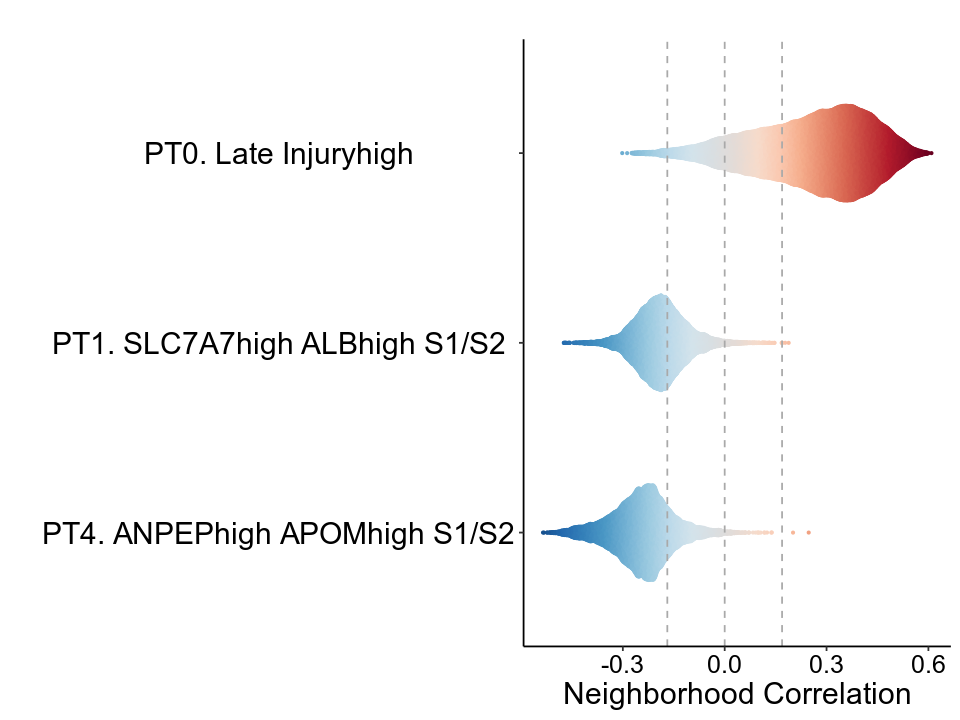

In [118]:
fig.size(6, 8)
subset <- c('PT1. SLC7A7high ALBhigh S1/S2', 'PT4. ANPEPhigh APOMhigh S1/S2', 'PT0. Late Injuryhigh')
ggplot(meta %>% filter(final_annotation %in% subset), 
           aes(y = reorder(final_annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
 #   scale_x_discrete(limits = cluster_order) +
    labs( x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

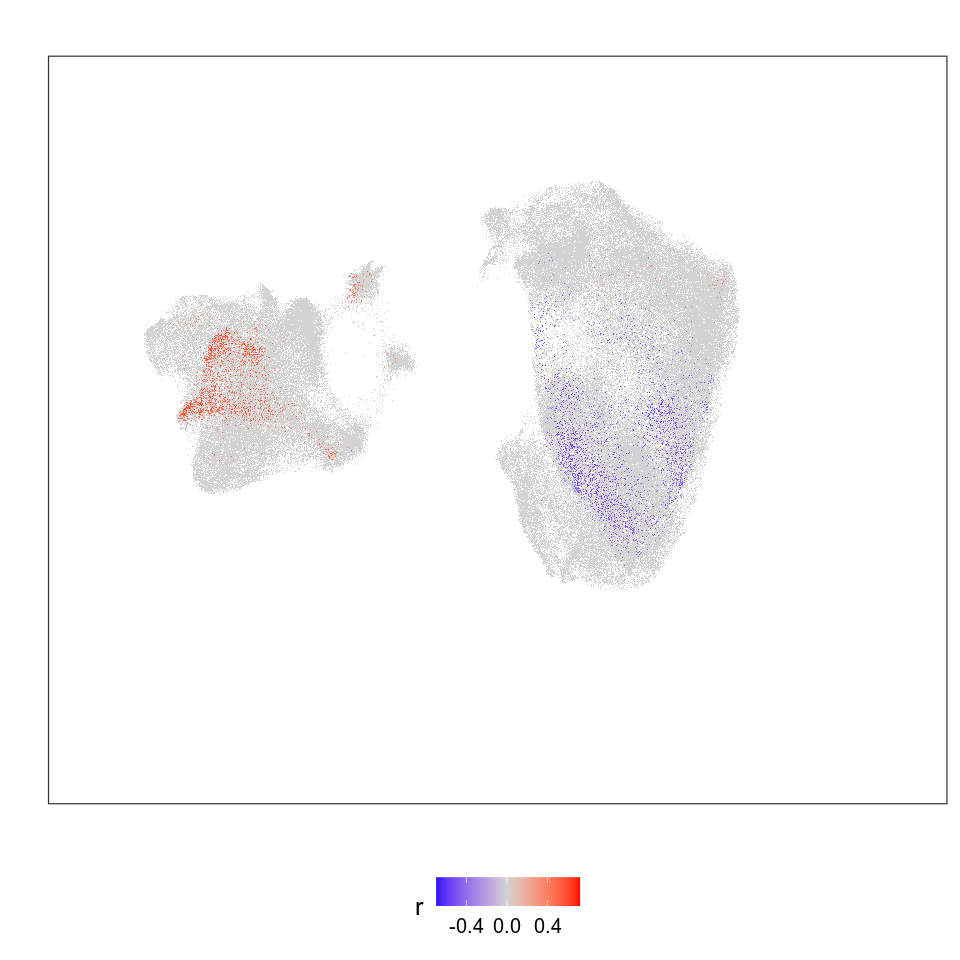

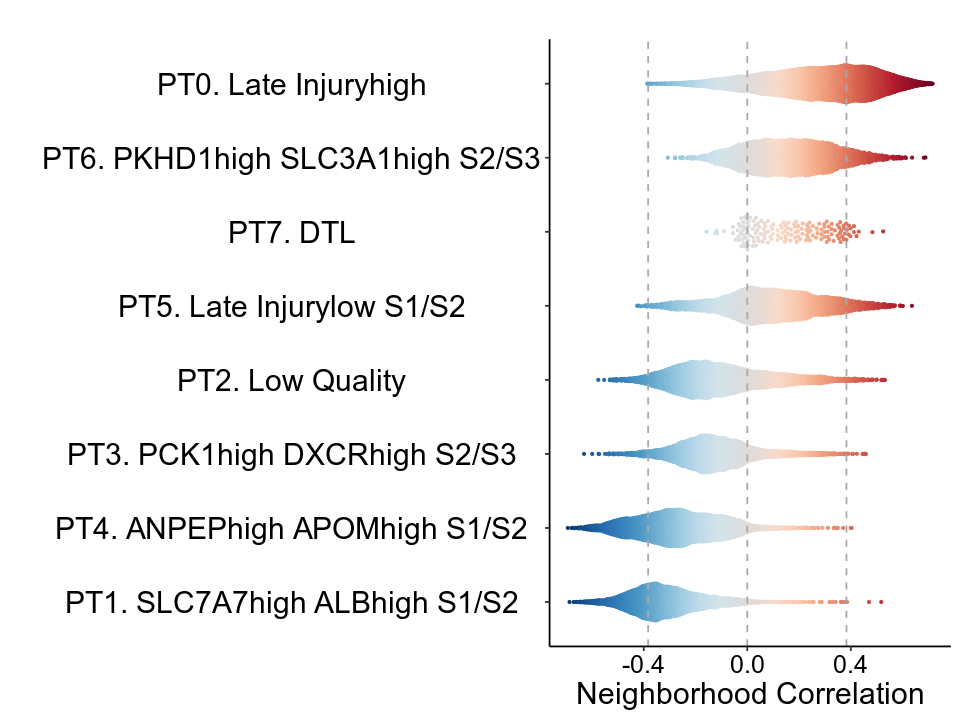

In [76]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/chronicity/sn_meta.csv')
umap <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/chronicity/sn_umap.csv')
ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/chronicity/sn_conditional_ncorr.csv", header = FALSE)
fdrs <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/chronicity/sn_conditional_fdrs.csv", header = FALSE)
colnames(fdrs) <- c('threshold', 'fdr', 'ncells')
meta$ncorr <- ncorr$V1

fdr_5 <- fdrs %>% filter(fdr < 0.05) %>% 
            mutate(fdr = round(fdr, 4)) %>% 
            filter(fdr == max(fdr)) %>% 
            pull(threshold)

tmp_meta <- meta %>% 
                    mutate(ncorr = ifelse(abs(meta$ncorr) > fdr_5, ncorr, NA)) 
tmp_meta <- tmp_meta %>% cbind(umap)

fig.size(8, 8)
ggplot() + 
      geom_point(data = pt_meta,
                 aes(x = huwotUMAP1, y = huwotUMAP2), color = 'lightgrey',
                    size = 0.1, shape = 20, stroke = 0.0001) +
      geom_point(
      data = tmp_meta[sample(nrow(tmp_meta)),] %>% rename(correlation = ncorr), 
          aes(x = huwotUMAP1, y = huwotUMAP2, color = correlation),
          size = 0.1, shape = 20, stroke = 0.0001
) + 
      scale_color_gradient2(low = 'blue', mid = 'lightgray', high = 'red', na.value = "lightgrey") + 
      labs(x="", y="", title = "", color = "r") +
      theme_bw(base_size = 15) +
  theme( legend.position = "bottom",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", hjust = 0.5, face = "bold", size=20)
  ) +
scale_x_continuous(limits = c(-12, 12)) +
scale_y_continuous(limits = c(-8, 6)) 

pos_fdr_thresh <- fdr_5
neg_fdr_thresh <- -1 * fdr_5

interval <- c(-max(abs(meta$ncorr)), max(abs(meta$ncorr)))


myPalette <- colorRampPalette(c(RColorBrewer::brewer.pal(11, "RdBu")[11:7], "#DCDCDC", RColorBrewer::brewer.pal(11, "RdBu")[5:1]))
fig.size(6, 8)

cluster_order <- meta %>% select(final_annotation, ncorr) %>% 
                    group_by(final_annotation) %>% summarize(ncorr = mean(ncorr)) %>% 
                    arrange(ncorr) %>% pull(final_annotation)

ggplot(meta, aes(y = reorder(final_annotation, ncorr), x = ncorr)) +
    ggbeeswarm::geom_quasirandom(aes(color = ncorr), width = 0.25, size = 0.5) +
    geom_vline(xintercept = neg_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = pos_fdr_thresh, linetype = "dashed", color = "darkgrey") +
    geom_vline(xintercept = 0, linetype = "dashed", color = "darkgrey") +
    scale_colour_gradientn(colours = myPalette(20), limits = interval) +
 #   scale_x_discrete(limits = cluster_order) +
    labs( x= "Neighborhood Correlation", y = "", title = "") +
    theme_classic() +
    theme(
        legend.position = "none",
        panel.grid = element_blank(),
        axis.text.x = element_text(color = "black", size = 15, hjust=0.5),
        axis.text.y = element_text(color = "black", size = 18, hjust=0.5),
        axis.title = element_text(size=18, hjust = 0.5))

In [36]:
pt_norm <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/PT_qcd_norm_12072023.rds')

In [38]:
meta <- meta %>% cbind(umap)

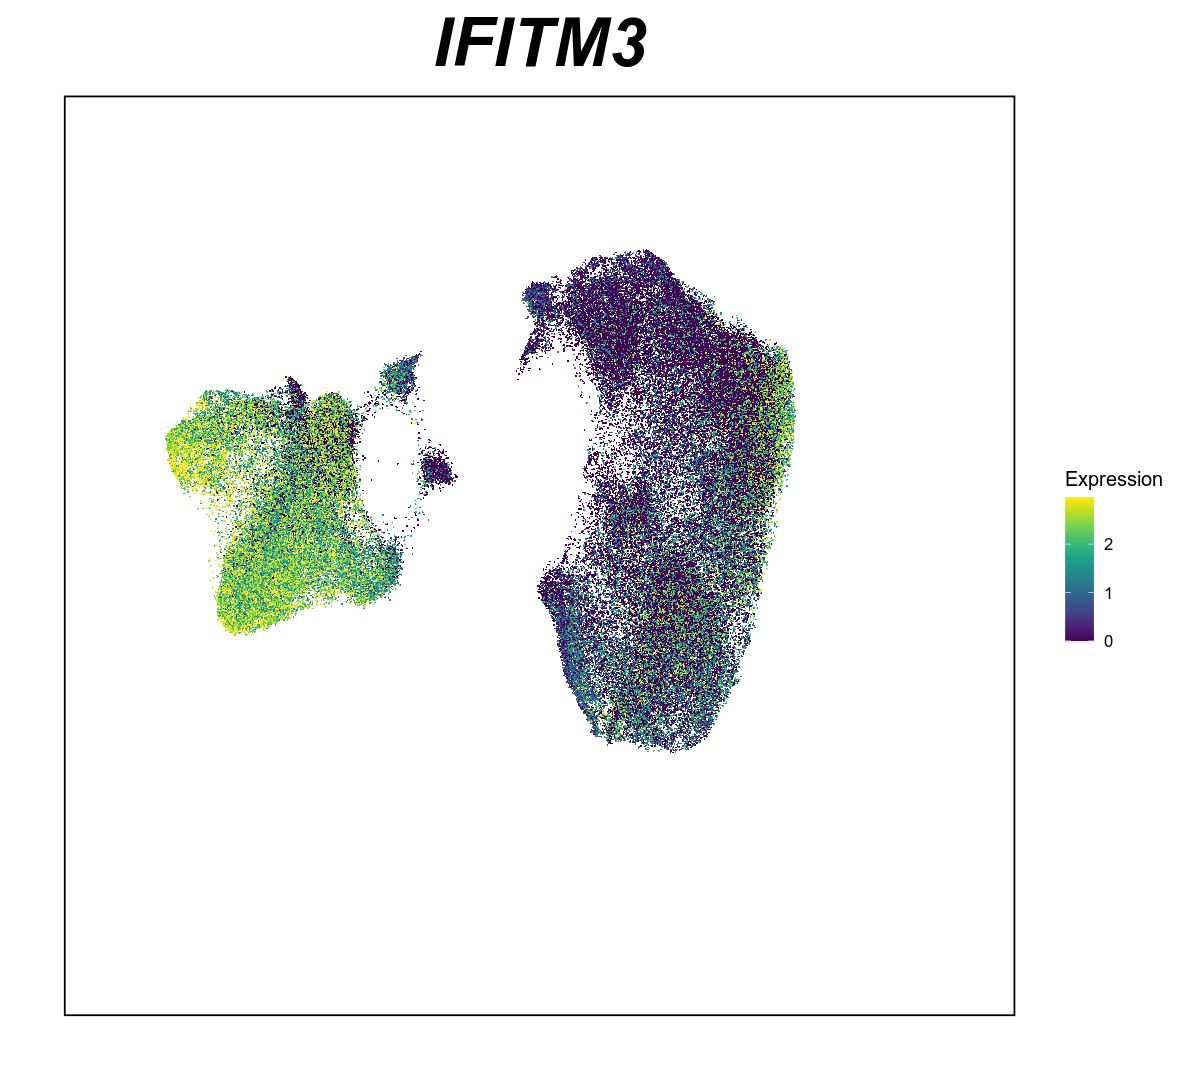

In [45]:
fig.size(9, 10)
plot_shuffled_features(meta, 
                       pt_norm, "IFITM3", 
                       pct = 0.95, 
                       pt_size = 0.75) + 
    theme(plot.title = element_text(size = 40),
                    panel.border = element_rect(colour = "black", fill=NA, size=1)) +
scale_x_continuous(limits = c(-12, 12)) +
scale_y_continuous(limits = c(-8, 6)) 

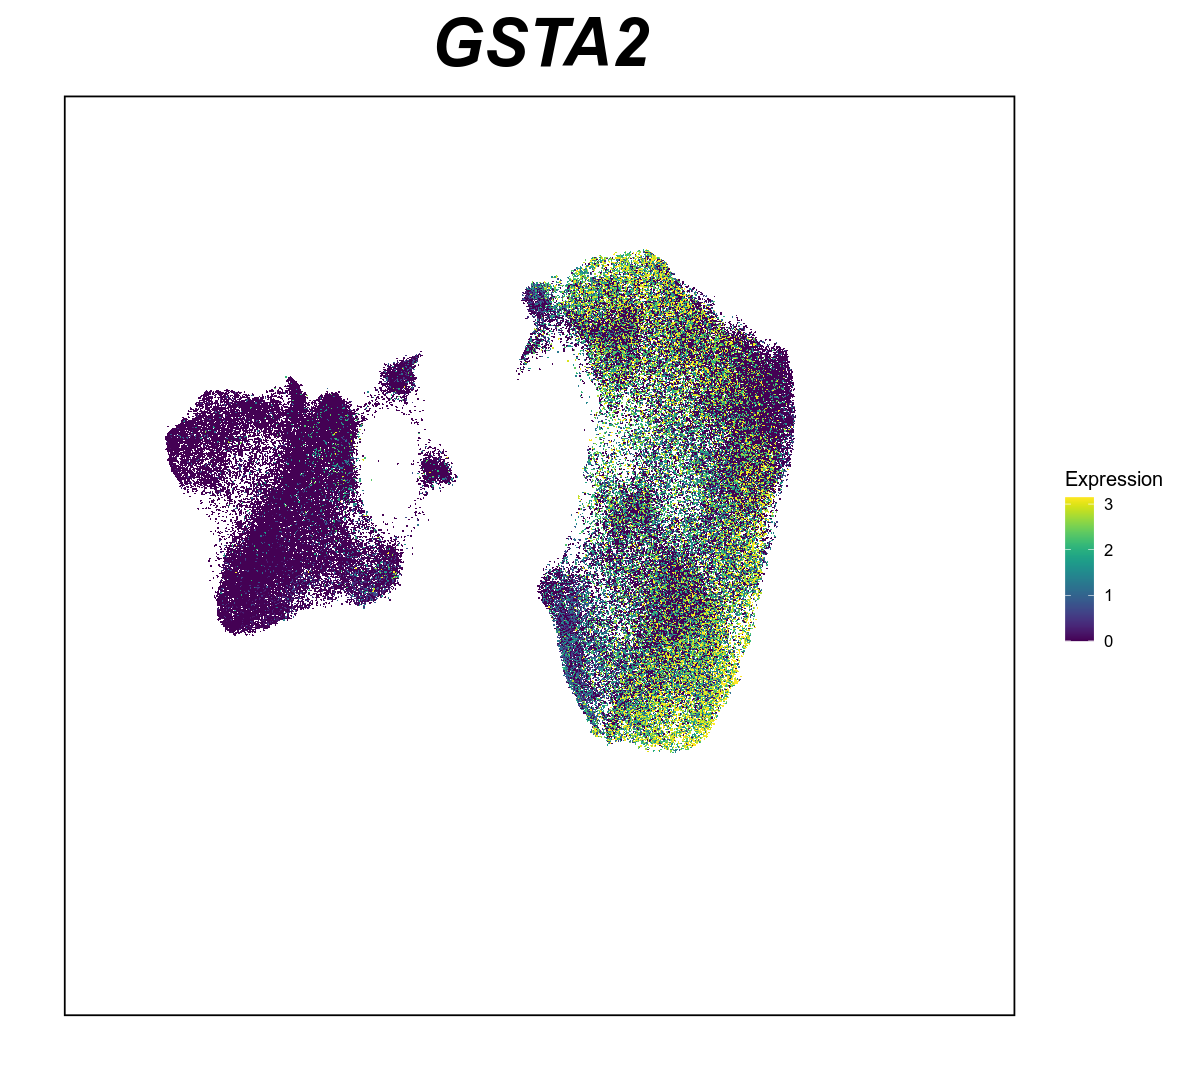

In [46]:
fig.size(9, 10)
plot_shuffled_features(meta, 
                       pt_norm, "GSTA2", 
                       pct = 0.95, 
                       pt_size = 0.75) + 
    theme(plot.title = element_text(size = 40),
                    panel.border = element_rect(colour = "black", fill=NA, size=1)) +
scale_x_continuous(limits = c(-12, 12)) +
scale_y_continuous(limits = c(-8, 6)) 

In [53]:
sc_meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/chronicity/sc_meta.csv')
sc_ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/chronicity/sc_conditional_ncorr.csv", header = FALSE)
sc_meta$ncorr <- sc_ncorr$V1
sn_meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/chronicity/sn_meta.csv')
sn_ncorr <- read.csv("/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/chronicity/sn_conditional_ncorr.csv", header = FALSE)
sn_meta$ncorr <- sn_ncorr$V1

final_annotation <- data.frame(hres.0.4 = as.factor(seq(0, 7)),
                               final_annotation = c("PT0. Late Injuryhigh",
                                                    "PT1. SLC7A7high ALBhigh S1/S2",
                                                    "PT2. Low Quality",
                                                    "PT3. PCK1high DXCRhigh S2/S3",
                                                    "PT4. ANPEPhigh APOMhigh S1/S2",
                                                    "PT5. Late Injurylow S1/S2",
                                                    "PT6. PKHD1high SLC3A1high S2/S3",
                                                    "PT7. DTL"))

sc_meta <- left_join(sc_meta, final_annotation) %>% mutate(new_cluster_number = hres.0.4)
sn_meta <- left_join(sn_meta, final_annotation) %>% mutate(new_cluster_number = hres.0.4)

sc_summary <- sc_meta %>% 
                select(new_cluster_number, cell, ncorr) %>% 
                group_by(new_cluster_number) %>% 
                summarize(sc.ncorr.ci = paste0("(", round(mean(ncorr) - 1.96 * sd(ncorr) / sqrt(length(cell)), 3),
                                      ", ", round(mean(ncorr) + 1.96 * sd(ncorr) / sqrt(length(cell)), 3), ")"))
sn_summary <-  sn_meta %>% 
                select(new_cluster_number, cell, ncorr) %>% 
                group_by(new_cluster_number) %>% 
                summarize(sn.ncorr.ci = paste0("(", round(mean(ncorr) - 1.96 * sd(ncorr) / sqrt(length(cell)), 3),
                                      ", ", round(mean(ncorr) + 1.96 * sd(ncorr) / sqrt(length(cell)), 3), ")"))
summary <- sc_summary %>% left_join(sn_summary)
write.table(summary, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/pt_chronicity_corr_04152024.csv', 
              quote = FALSE, row.names = FALSE, sep = "\t")

Joining, by = "final_annotation"
Joining, by = "final_annotation"
Joining, by = "new_cluster_number"


### DE

In [4]:
de <- function(feature, df) {
    model_df <- df %>% select(feature, sample, First_biop, Responder_Status, 
                              Final_Chronicity, avg_count, avg_mt) %>% rename(Exp = feature)
    if (sum(model_df$Exp > 0) > 0.05 * nrow(model_df)) { 
        m_0 <- lm(Exp ~ log(avg_count) + avg_mt, data = model_df)
        m_1 <- lm(Exp ~ log(avg_count) + avg_mt + Final_Chronicity, data = model_df)
        ANNO <- anova(m_0, m_1)
        LRP <- ANNO[2,6]
        F <- ANNO[2,5]
        Beta <- summary(m_1)$coefficients['Final_Chronicity', 'Estimate']
        SE <- summary(m_1)$coefficients['Final_Chronicity', 'Std. Error']
        res <- c(gene = feature, LRP = LRP, F = F, Beta = Beta, SE = SE)
    }
    else {
        res <- c(gene = feature, LRP = NA, F = NA, Beta = NA, SE = NA)
    }
    return(res)
}

In [5]:
meta <- read.csv('/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/chronicity/sc_meta.csv')
pt_pb <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/PT_norm_pseudobulk_12072023.rds')

In [6]:
pt_pb <- pt_pb %>% 
                filter(sample %in% unique(meta$sample)) %>% 
                left_join(meta %>% 
                              select(sample, First_biop, Responder_Status, Final_Chronicity) %>% 
                              unique())

Joining, by = "sample"


In [7]:
de_out <- mclapply(colnames(pt_pb)[1:36601], de, pt_pb, mc.cores = 20)

In [8]:
de_df <- data.frame(do.call(rbind, de_out)) %>% mutate(LRP = as.numeric(LRP),
                                                       F = as.numeric(F),
                                                       Beta = as.numeric(Beta),
                                                       SE = as.numeric(SE))

In [9]:
saveRDS(de_df, '/data/srlab/ssg34/SLE_kidney_v2/data/tissue/PT_chronicity_differential_expression_03082024.rds')

In [39]:
de_df <- readRDS('/data/srlab/ssg34/SLE_kidney_v2/data/tissue/PT_chronicity_differential_expression_03082024.rds')

In [40]:
de_df <- de_df %>% 
            na.omit() %>% 
            arrange(LRP) %>% 
            mutate(FDR = p.adjust(LRP, method = "BH")) 

In [44]:
de_df %>% filter(gene == "IFITM3")

gene,LRP,F,Beta,SE,FDR
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IFITM3,0.002254472,9.691216,0.05602151,0.01799557,0.0101598


In [28]:
genes <- c("NNMT", "MMP7", "TIMP1", "ANXA2", "WFDC2", "S100A6", "MIOX",
           "MIOX", "FTL", "FABP1", "APOE", "GSTA2", "IFITM3")

Warning message:
“Removed 26903 rows containing missing values (`geom_text_repel()`).”
Warning message:
“ggrepel: 29 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


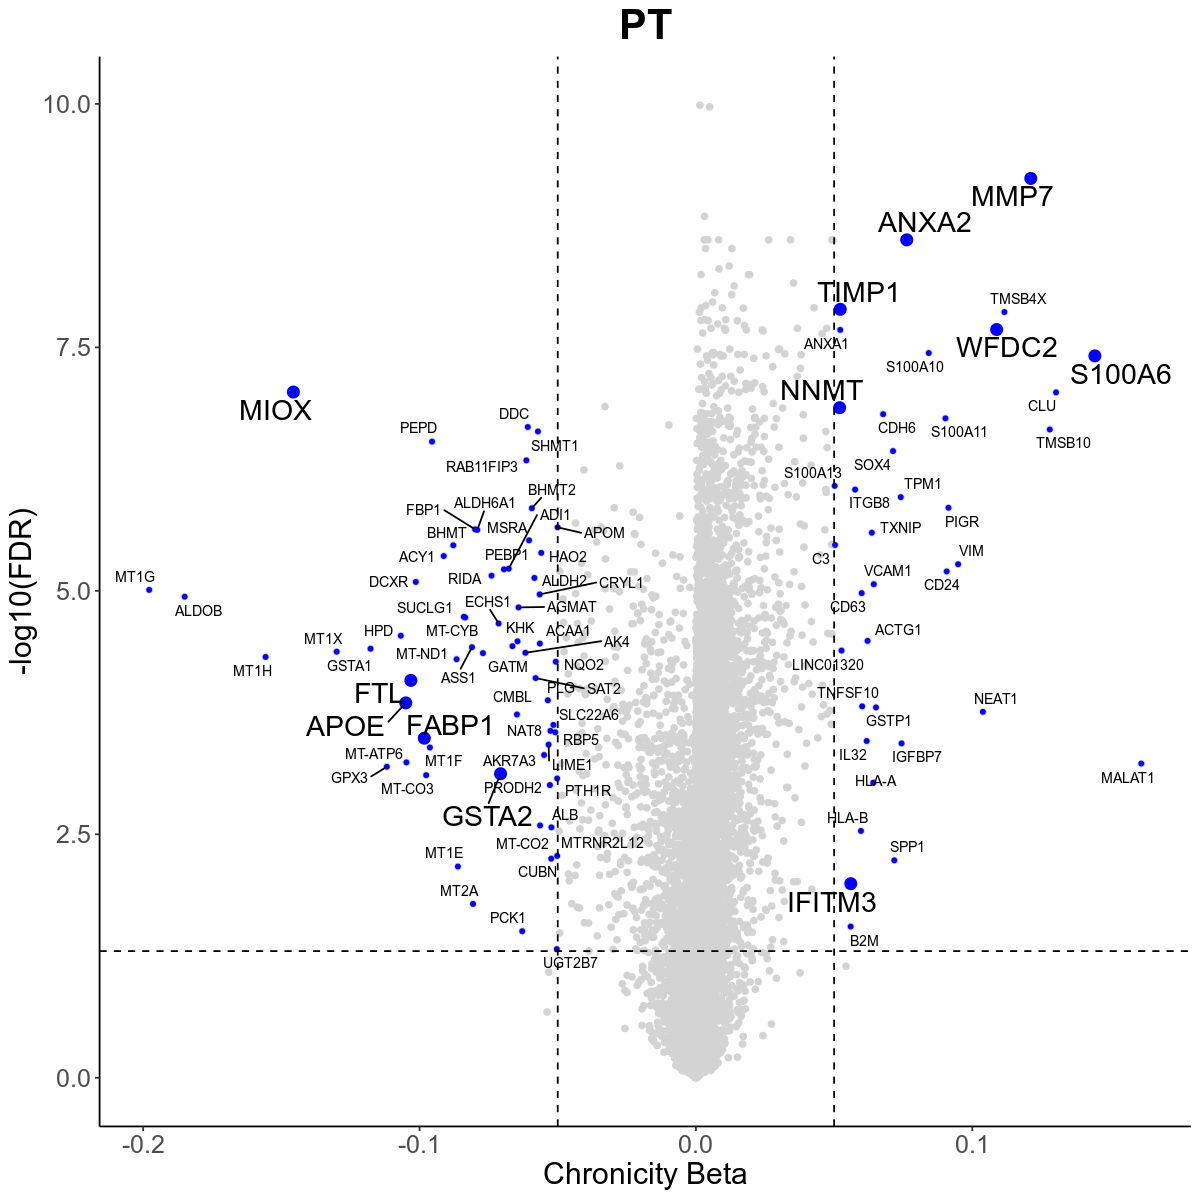

In [30]:
fig.size(10, 10)
ggplot(de_df,
                aes(x = Beta, y = -log10(FDR))) +
    geom_point(colour = 'lightgrey') + 
    geom_point(data = de_df %>% filter(FDR < 0.05 & abs(Beta) >= 0.05,
                                        ! gene %in% genes),
                   aes(x = Beta, y = -log10(FDR)),  color = "blue", size = 1) +
    geom_point(data = de_df %>% filter(gene %in% genes),
                   aes(x = Beta, y = -log10(FDR)),  color = "blue", size = 3)  + 
    geom_vline(xintercept = c(-0.05, 0.05), linetype = "dashed") + 
    geom_hline(yintercept = -log10(0.05), linetype = "dashed") + 
    theme_classic() + 
    theme(legend.position = "none",
          axis.text = element_text(size = 15),
          axis.title = element_text(size = 18),
          plot.title = element_text(size = 25, hjust = 0.5, face = "bold")) +
    ggrepel::geom_text_repel(data = de_df %>% 
                                     mutate(label = ifelse(FDR < 0.05 & abs(Beta) >= 0.05 | 
                                                           gene %in% genes, gene, NA),
                                            label_size = ifelse(gene %in% genes, 6 , 3)),
                                     aes(x = Beta, y = -log10(FDR), 
                                         size = label_size, label = label)
            , color = "black") +
    scale_size_identity() + 
    labs(x = "Chronicity Beta", y = "-log10(FDR)", title = "PT")

## ACTIVITY

In [4]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_Activity)]
meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/activity/sc_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/activity/sc_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/activity/sc_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


In [5]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))

harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_Activity)]
meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")

write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/activity/sn_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/activity/sn_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/activity/sn_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


## ISN

In [25]:
meta <- sc_meta %>% select(-c(colnames(sc_meta[grep('hPC-', colnames(sc_meta))]), 
                          colnames(sc_meta[grep('huwotUMAP', colnames(sc_meta))])))
harmony <- sc_meta %>% select(colnames(sc_meta)[grep('hPC-', colnames(sc_meta))])

umap <- sc_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_ISN)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")
write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/ISN/sc_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/ISN/sc_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/ISN/sc_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"


In [26]:
meta <- sn_meta %>% select(-c(colnames(sn_meta[grep('hPC-', colnames(sn_meta))]), 
                          colnames(sn_meta[grep('huwotUMAP', colnames(sn_meta))])))
harmony <- sn_meta %>% select(colnames(sn_meta)[grep('hPC-', colnames(sn_meta))])

umap <- sn_meta %>% select(c(huwotUMAP1, huwotUMAP2))

ind <- c(1:nrow(meta))[!is.na(meta$Final_ISN)]

meta <- meta[ind, ]
harmony <- harmony[ind, ]
umap <- umap[ind, ]

meta$Age <- as.numeric(scale(meta$Age))
meta$Sex <- as.numeric(as.factor(meta$Sex))
meta$Final_Chronicity <- as.factor(as.numeric(meta$Final_Chronicity))
meta$Final_Activity <- as.factor(as.numeric(meta$Final_Activity))

meta <- meta %>% left_join(data.frame(Responder.Status = c("NR", "PR", "CR"),
                                      Responder_Status = c(0, 1, 2)))

meta$Responder_Status <- as.numeric(meta$Responder_Status)
meta$First_biop <- as.numeric(meta$First_biop)
meta$Pred_use <- as.numeric(meta$Pred_use)



meta <- fastDummies::dummy_cols(meta, "Race")
meta <- fastDummies::dummy_cols(meta, "Final_ISN")
meta <- fastDummies::dummy_cols(meta, "Final_Site")
write.csv(meta, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/ISN/sn_meta.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(harmony, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/ISN/sn_harmony.csv', 
          row.names = FALSE, quote = FALSE)
write.csv(umap, '/data/srlab/ssg34/SLE_kidney_v2/data/cna_new/PT/ISN/sn_umap.csv', 
          row.names = FALSE, quote = FALSE)

Joining, by = "Responder.Status"
